In [61]:
import numpy as np
import pandas as pd
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from data import data_keys
from sklearn.feature_selection import RFE
from sklearn.svm import SVR
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer as SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import seaborn as sns
import helpers
import operator
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
%matplotlib inline
import matplotlib.pyplot as plt

In [62]:
import importlib
importlib.reload(helpers)

<module 'helpers' from 'C:\\Users\\Zack\\Dropbox\\Assignment\\Pathrise\\airbnb_dataset_challenge\\helpers.py'>

This is a relatively large dataset with about 100 columns.
For this challenge, the variables we would try to predict are prices and availability.

In [63]:
df = pd.read_csv("./data/listings.csv")
print("Shape: ", df.shape)
df.describe()

Shape:  (20677, 106)


,id,scrape_id,thumbnail_url,medium_url,xl_picture_url,host_id,host_acceptance_rate,host_listings_count,host_total_listings_count,neighbourhood_group_cleansed,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
count,2.067700e+04,2.067700e+04,0.0,0.0,0.0,2.067700e+04,0.0,20665.000000,20665.000000,0.0,...,17852.000000,17840.000000,17847.000000,17842.000000,17842.000000,20677.000000,20677.000000,20677.000000,20677.000000,18084.000000
mean,1.791013e+07,2.019081e+13,NaN,NaN,NaN,5.666981e+07,NaN,7.010888,7.010888,NaN,...,9.469079,9.735762,9.789488,9.476124,9.177054,4.925134,4.492431,0.410988,0.021715,0.987736
std,1.041987e+07,7.800970e+00,NaN,NaN,NaN,6.812902e+07,NaN,37.729548,37.729548,NaN,...,0.867372,0.654358,0.610074,0.707655,0.808275,22.883678,22.710906,1.082794,0.237805,1.349155
min,2.818000e+03,2.019081e+13,NaN,NaN,NaN,3.159000e+03,NaN,0.000000,0.000000,NaN,...,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,9.340207e+06,2.019081e+13,NaN,NaN,NaN,8.795077e+06,NaN,1.000000,1.000000,NaN,...,9.000000,10.000000,10.000000,9.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.240000
50%,1.774427e+07,2.019081e+13,NaN,NaN,NaN,2.618942e+07,NaN,1.000000,1.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,9.000000,1.000000,1.000000,0.000000,0.000000,0.540000
75%,2.601974e+07,2.019081e+13,NaN,NaN,NaN,7.754037e+07,NaN,2.000000,2.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,1.000000,1.000000,1.000000,0.000000,1.070000
max,3.759099e+07,2.019081e+13,NaN,NaN,NaN,2.839422e+08,NaN,980.000000,980.000000,NaN,...,10.000000,10.000000,10.000000,10.000000,10.000000,208.000000,206.000000,15.000000,8.000000,33.670000


Work with availability first

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002C4D35FD898>,
      dtype=object)

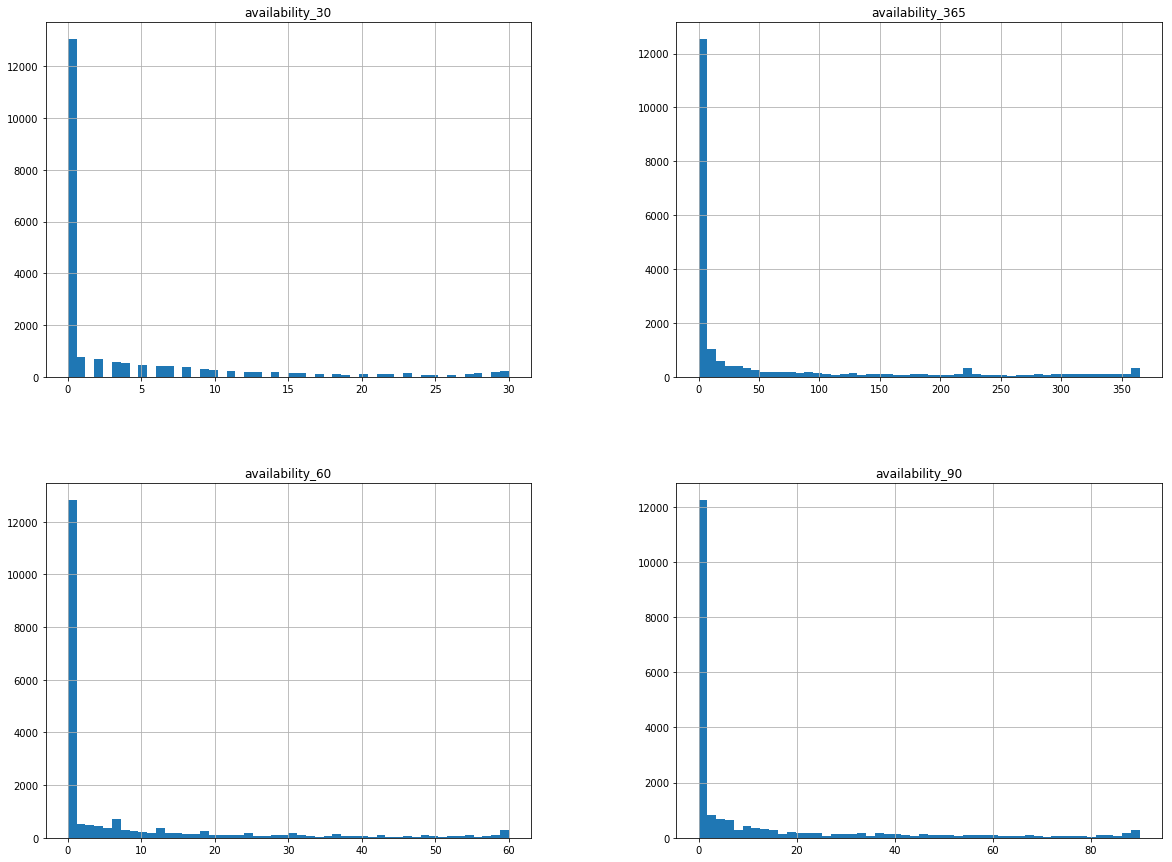

In [64]:
avail_df = df[['availability_30', 'availability_60', 'availability_90', 'availability_365']]
avail_df.hist(bins=50, figsize=(20,15))

The distribution of availability is non-normal and has very wide (uniform after 0) spread.
Thus, we could bin the variable into some intervals. 

Notice the std increases as the time length considered increases, thus differentiating the listings more.
Let's use 'availability_365' since they are all highly correlated and the availability for 365 days could eliminate short-term fluctuations that we don't care.
* Note the types/locations might be good predictors for short-term availability.

In [65]:
df = df[data_keys.primary_num_cols + ["price"]]

Data cleaning

In [66]:
# convert it to a numerical column
nan_ptc_dict = {}
for price_col in list(df):
    count_nan = len(df[price_col]) - df[price_col].count()
    if (count_nan):
        nan_ptc_dict[f"nan percentage for {price_col}"] = count_nan / len(df)

In [67]:
sorted_d = sorted(nan_ptc_dict.items(), key=operator.itemgetter(1), reverse=True)
print(sorted_d)

[('nan percentage for square_feet', 0.9813319146878173), ('nan percentage for host_response_rate', 0.4130676597185278), ('nan percentage for security_deposit', 0.29994680079315184), ('nan percentage for cleaning_fee', 0.17995840789282777), ('nan percentage for review_scores_checkin', 0.1372055907530106), ('nan percentage for review_scores_location', 0.13710886492237753), ('nan percentage for review_scores_value', 0.13710886492237753), ('nan percentage for review_scores_communication', 0.13686705034579486), ('nan percentage for review_scores_accuracy', 0.13672196159984523), ('nan percentage for review_scores_cleanliness', 0.13662523576921218), ('nan percentage for review_scores_rating', 0.13618996953136336), ('nan percentage for bedrooms', 0.00038690332253228226), ('nan percentage for beds', 0.00038690332253228226), ('nan percentage for bathrooms', 0.0002901774918992117)]


Most variables are relatively complete. We would drop square_feet.  

In [68]:
df.drop(['square_feet'], axis = 1, inplace = True)

In [69]:
df["host_response_rate"] = df["host_response_rate"].apply(lambda x: helpers.percent_to_float(x))

for col in ["price", "security_deposit", "cleaning_fee", "extra_people"]:
    df[col] = df[col].apply(lambda x: helpers.convert_string_to_dollar(str(x)))

df = df[(df["price"] > 0) &
        (df["accommodates"] > 0)]

Let's check their distributions out.

In [70]:
sns.pairplot(df).savefig("./imgs/pairplot.png")
plt.close() # too many variables for inline plots

Correlation Heatmap

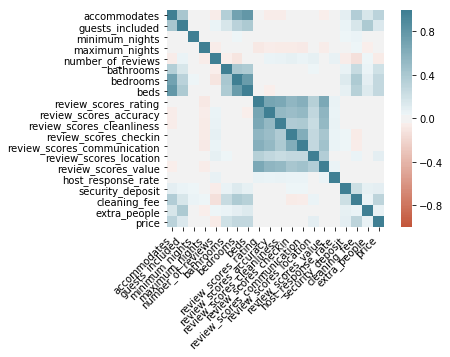

In [71]:
helpers.corr_heatmap(df.corr())

Feature Transformation

Many variables are right skewed, so let's try log transformation

In [72]:
to_log_transform = ["price", "security_deposit", "cleaning_fee", "extra_people",
            "bathrooms", "bedrooms", "beds",
            "number_of_reviews"]
for col in to_log_transform:
    df[f"log_{col}"] = np.log(df[col] + 1)

Feature Engineering

In [73]:
base_col = "accommodates"
for col in ["bedrooms", "bathrooms"]:
    df[f"{col}_per_{base_col}"] = df[col] / df[base_col]

In [74]:
df['avg_review'] = df[['review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value']].mean(axis=1)

df[['review_scores_rating',
    "avg_review",
        'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value',]].corr()

,review_scores_rating,avg_review,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value
review_scores_rating,1.000000,0.813368,0.683038,0.660347,0.541946,0.597463,0.342277,0.662979
avg_review,0.813368,1.000000,0.780069,0.740820,0.714878,0.729915,0.560879,0.785463
review_scores_accuracy,0.683038,0.780069,1.000000,0.530813,0.484389,0.528306,0.288246,0.548149
review_scores_cleanliness,0.660347,0.740820,0.530813,1.000000,0.374927,0.395964,0.242589,0.522499
review_scores_checkin,0.541946,0.714878,0.484389,0.374927,1.000000,0.618134,0.277944,0.429079
review_scores_communication,0.597463,0.729915,0.528306,0.395964,0.618134,1.000000,0.266880,0.457579
review_scores_location,0.342277,0.560879,0.288246,0.242589,0.277944,0.266880,1.000000,0.360936
review_scores_value,0.662979,0.785463,0.548149,0.522499,0.429079,0.457579,0.360936,1.000000


Actually there is not too strong correlations between the different types of reviews, for now let's just use review_scores_rating.

In [75]:
df.drop(["avg_review",
        'review_scores_accuracy', 'review_scores_cleanliness',
        'review_scores_checkin', 'review_scores_communication',
        'review_scores_location', 'review_scores_value'
         ], axis = 1, inplace = True)

Delete redundant variables

In [76]:
df.drop(to_log_transform, axis = 1, inplace = True)

Delete less useful variables

In [77]:
df.drop(["minimum_nights", "maximum_nights"
         ], axis = 1, inplace = True)

Inspect the pairplot and heatmap again.

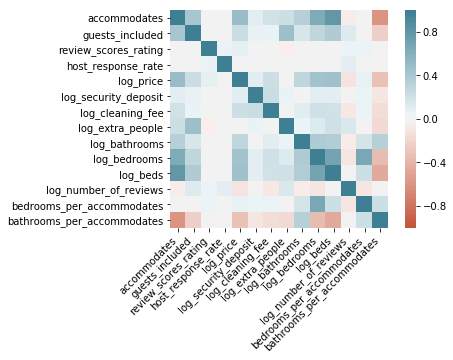

In [78]:
sns.pairplot(df).savefig("./imgs/transformed_pairplot.png")
plt.close() # too many variables for inline plots
helpers.corr_heatmap(df.corr())

The new plots look good.

Pipeline for imputing and standardizing data

In [ ]:
# num_pipeline = Pipeline([
#         ('imputer', SimpleImputer(strategy="median")),
#         ('std_scaler', StandardScaler()),
#     ])
# 

In [ ]:
# full_pipeline = ColumnTransformer([
#         ("num", num_pipeline, data_keys.binary_cols + data_keys.cat_cols),
#         ("cat", OneHotEncoder(), ),
#     ])

Feature Elimination

In [79]:
# estimator = SVR(kernel="linear")
# selector = RFE(estimator, 5, step=1)
# selector = selector.fit(X, y)
# selector.support_ 
# 

In [80]:
# selector.ranking_
# for i in range(len(list(X))):
#     if selector.ranking_[i] == 1:
#         print(list(X)[i])



Future Improvement
* use auto-transformers (https://datamadness.github.io/Skewness_Auto_Transform)
